In [1]:
from tkinter import N
from joblib import PrintTime
import pvlib
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import daytime
import Funciones  
import seaborn as sns
from scipy import stats
from sklearn.metrics import mean_squared_error

# Locación a Evaluar
Para esta investigación se decidió reducir las posibles a distintas partes de Colombia. se evaluará el efecto que tendrían distintos paneles 

In [2]:
tz = 'America/Bogota'
#El paso
lat, lon = 9.789103, -73.722451 # 9.789103, -73.722451 Esta es las coordenas
altitude = 50
#La guajira
#lat, lon = 9.789103, -73.722451
#
location = pvlib.location.Location(lat, lon, tz, altitude)

api_key = 'rMYPYAhkiXjb9WUAjQVU728EI59XhF2TeY9ml5cz'
email = 'da.parral@uniandes.edu.co'
tmy, header = pvlib.iotools.get_psm3(lat, lon, api_key, email, 
                                            names='2020')

KeyboardInterrupt: 

In [ ]:
tmy_columns_rename = ['Year', 'Month', 'Day', 'Hour', 'Minute', 'temp_air', 'Dew Point', 'dhi', 'dni', 'ghi', 'albedo', 'Pressure', 'Wind Direction', 'wind_speed']
tmy.columns = tmy_columns_rename


In [ ]:
solpos = pvlib.solarposition.get_solarposition(tmy.index, lat, lon)
# remove nighttime
tmy = tmy.loc[solpos['apparent_elevation'] > 0, :]
solpos = solpos.loc[solpos['apparent_elevation'] > 0, :]

# Funciones

In [ ]:
def irrad_total_bifacial(front,back, bifaciality):
    try:
        x=back.mul(bifaciality)
        irrad=front.add(x)
        return(irrad)
    except: 
        print("irrad_total_bifacial failed")

In [ ]:
def dc_production(effective_irradiance, module_temperature,module,system):
    #Single Diode Parameters
    IL, I0, Rs, Rsh, nNsVth = pvlib.pvsystem.calcparams_cec(effective_irradiance,
                                                      module_temperature,
                                                      module['alpha_sc'],
                                                      module['a_ref'],
                                                      module['I_L_ref'],
                                                      module['I_o_ref'],
                                                      module['R_sh_ref'],
                                                      module['R_s'],
                                                      module['Adjust'],
                                                      EgRef=1.121,
                                                      dEgdT=-0.0002677)

    curve_info = pvlib.pvsystem.singlediode(photocurrent=IL,
                                      saturation_current=I0,
                                      resistance_series=Rs,
                                      resistance_shunt=Rsh,
                                      nNsVth=nNsVth,
                                      ivcurve_pnts=100,
                                      method='lambertw')

    #Scalating CEC et. al. Single Diode Results
    data_i_sc = pd.Series(curve_info['i_sc'])
    data_v_oc = pd.Series(curve_info['v_oc'])
    data_i_mp = pd.Series(curve_info['i_mp'])
    data_v_mp = pd.Series(curve_info['v_mp'])
    data_p_mp = pd.Series(curve_info['p_mp'])
    data_i_x = pd.Series(curve_info['i_x'])
    data_i_xx = pd.Series(curve_info['i_xx'])

    results_general = pd.DataFrame({'i_sc': data_i_sc, 
                                    'v_oc': data_v_oc,
                                    'i_mp': data_i_mp, 
                                    'v_mp': data_v_mp, 
                                    'p_mp': data_p_mp, 
                                    'i_x': data_i_x,
                                    'i_xx': data_i_xx})

    #DC Dataframe
    datetime_index = effective_irradiance.index

    dc = system.scale_voltage_current_power(results_general)
    dc = dc.set_index(datetime_index)

    
    
    return dc

In [ ]:
def losses(dc, loss):

    losses = loss/100 #According to the paper Performance Parameters for Grid-Connected PV Systems by NREL

    #Losses System A
    dc['i_mp'] = dc['i_mp'] - dc['i_mp']*losses
    dc['p_mp'] = dc['p_mp'] - dc['p_mp']*losses


    return dc

In [ ]:
def pvlib_ac_power(dc,inverter, total_inversores=1):
    ac= pvlib.inverter.sandia(dc['v_mp'], dc['p_mp'], inverter)
    
    
    pvlib_ac = ac * total_inversores
    
    pvlib_ac.loc[pvlib_ac < 0] = 0
    pvlib_ac.fillna(value=0, inplace=True)
    
    return pvlib_ac

# Especificaciones

In [ ]:
modules_database = 'CECMOD'
modules = pvlib.pvsystem.retrieve_sam(modules_database)

modules.to_csv("DB.csv")
module=modules.LG_Electronics_Inc__LG370N2T_A4
print(module)

Technology            Mono-c-Si
Bifacial                      1
STC                      370.76
PTC                       340.6
A_c                        1.95
Length                     1.99
Width                      0.98
N_s                          72
I_sc_ref                   9.78
V_oc_ref                   48.8
I_mp_ref                    9.2
V_mp_ref                   40.3
alpha_sc               0.002934
beta_oc                -0.13176
T_NOCT                     46.8
a_ref                  1.829992
I_L_ref                9.790371
I_o_ref                     0.0
R_s                    0.311815
R_sh_ref             294.038879
Adjust                 8.790824
gamma_r                   -0.37
BIPV                          N
Version       SAM 2018.11.11 r2
Date                   1/3/2019
Name: LG_Electronics_Inc__LG370N2T_A4, dtype: object


In [ ]:
inverters_database = 'CECInverter'
inverters = pvlib.pvsystem.retrieve_sam(inverters_database)
inverterx = inverters.Power_Electronics__FS1275CU15__690V_
print(inverterx)

Vac                          690
Pso                 12941.101563
Paco                   1389080.0
Pdco                   1421523.0
Vdco                      1030.0
C0                          -0.0
C1                      0.000007
C2                     -0.000112
C3                      0.000557
Pnt                      416.724
Vdcmax                    1200.0
Idcmax               1380.119417
Mppt_low                   976.0
Mppt_high                 1200.0
CEC_Date              10/15/2018
CEC_Type     Utility Interactive
Name: Power_Electronics__FS1275CU15__690V_, dtype: object


In [ ]:
mps_A = 30 #Modules Per String
spi_A = 150 #Strings Per Inverter


system_A = pvlib.pvsystem.PVSystem(module_parameters=module, 
                    inverter_parameters=inverterx, 
                    modules_per_string=mps_A, 
                    strings_per_inverter=spi_A)

# Evaluación de Altura y albedo


## Parametros 

In [ ]:
#Parametros
height=2
albedo=0.5
gcr=0.5
Backtrack=False
axis_azimuth=90
axis_tilt=0
max_angle=60
pvrow_width=0.98
bifacialty=0.95


Puntos a evaluar para hacer gráficas de contorno

In [ ]:
#[altura,gcr,ProduciónAc,]
Puntos=[[1,0.15],
        [1,0.25],
        [1,0.5],
        [1,0.75],
        [1.5,0.15],
        [1.5,0.25],
        [1.5,0.5],
        [1.5,0.75],
        [2,0.15],
        [2,0.25],
        [2,0.5],
        [2,0.75],
        [2.5,0.15],
        [2.5,0.25],
        [2.5,0.5],
        [2.5,0.75]]
Puntos_sol=Puntos.copy()
Dimension=4

In [ ]:
tracker = pvlib.tracking.singleaxis(apparent_zenith=solpos.apparent_zenith, 
                                    apparent_azimuth=solpos.azimuth, 
                                    axis_tilt=axis_tilt,
                                    axis_azimuth=axis_azimuth, #Heading south
                                    max_angle=max_angle, 
                                    backtrack=Backtrack, 
                                    gcr=gcr)
tracker = tracker.fillna(0)

In [ ]:
poa_front,poa_back,poa_frontabsorb,poa_backabsorb = pvlib.bifacial.pvfactors_timeseries(surface_tilt=tracker.surface_tilt, 
                                                                        surface_azimuth=tracker.surface_azimuth, 
                                                                        solar_zenith=solpos.zenith, 
                                                                        solar_azimuth=solpos.azimuth, 
                                                                        axis_azimuth=axis_azimuth,
                                                                        timestamps=tmy.index,
                                                                        dni=tmy.dni, 
                                                                        dhi=tmy.dhi,
                                                                        gcr=gcr,
                                                                        pvrow_height=height,
                                                                        pvrow_width=2*pvrow_width,
                                                                        #albedo=surface_albedo,
                                                                        albedo=albedo, 
                                                                        n_pvrows=3,
                                                                        index_observed_pvrow=1,
                                                                        rho_back_pvrow=0.05,
                                                                        rho_front_pvrow=0.03,
                                                                        horizon_band_angle=15)

C:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\viewfactors\vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)
C:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\viewfactors\vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)
C:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\viewfactors\vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)
C:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\viewfactors\vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)
C:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\v

In [ ]:
temp_cell = pvlib.temperature.sapm_module(poa_global=poa_front, 
                                        temp_air=tmy.temp_air, 
                                        wind_speed=tmy.wind_speed, 
                                        a=-3.47, 
                                        b=-0.0594)


## Código iterativo Bifacial

In [ ]:

M_m=1
poa_back_mat=[]
irrads=[]
dcs=[]
dcs_mono=[]
dcmeans=[]
dcmeans_mono=[]
ac=[]
acprod=[]
acprodt=[]
acprodp=[]
ac_mono=[]
acprod_mono=[]
acprod_monot=[]
acprod_monop=[]
BGs=[]
prods=[]
Puntos_sol=[]
prodsi=[]
hs=[]
gcrs=[]
n=0
for Punto in Puntos:
    
    h=Punto[0]
    gcr=Punto[1]
    albedo=Punto[2]
    Area_p=1.95
    Area_t=Area_p/gcr*mps_A*spi_A
    poa_fronti,poa_backi,poa_frontabsorbi,poa_backabsorbi = pvlib.bifacial.pvfactors_timeseries(surface_tilt=tracker.surface_tilt, 
                                                                        surface_azimuth=tracker.surface_azimuth, 
                                                                        solar_zenith=solpos.zenith, 
                                                                        solar_azimuth=solpos.azimuth, 
                                                                        axis_azimuth=axis_azimuth,
                                                                        timestamps=tmy.index,
                                                                        dni=tmy.dni, 
                                                                        dhi=tmy.dhi,
                                                                        gcr=gcr,
                                                                        pvrow_height=h,
                                                                        pvrow_width=2*pvrow_width,
                                                                        #albedo=surface_albedo,
                                                                        albedo=albedo, 
                                                                        n_pvrows=3,
                                                                        index_observed_pvrow=1,
                                                                        rho_back_pvrow=0.05,
                                                                        rho_front_pvrow=0.03,
                                                                        horizon_band_angle=15)
    

    poa_back_mat.append(poa_backabsorbi)
    irradi=irrad_total_bifacial(poa_frontabsorbi,
                     poa_backabsorbi,bifacialty)
    irrads.append(irradi)
    dc=dc_production(irradi,temp_cell,module,system_A)
    dc=losses(dc,20)
    dc_mono=dc_production(poa_frontabsorbi,temp_cell,module,system_A)
    dc_mono=losses(dc_mono,20)
    dcs.append(dc)
    dc_mean=dc.resample("7D").mean()
    dc_mono_mean=dc_mono.resample("7D").mean()
    dcmeans.append(dc_mean)
    dcmeans_mono.append(dc_mono_mean)
    aci=pvlib_ac_power(dc,inverterx)
    ac.append(aci)
    aci_mono=pvlib_ac_power(dc_mono,inverterx)
    aci_mono.append(aci)
    acprodi=aci.sum()
    acprodi_mono=aci.sum()
    acprodit=acprodi/Area_t
    acprodip=acprodi/Area_p
    acprodit_mono=acprodi_mono/Area_t
    acprodip_mono=acprodi_mono/Area_p

    acprod.append(acprodit)
    acprod_mono.append(acprodi_mono)
    BG=(acprodi/acprodi_mono)-1
    LCOE_star_i=(M_m+(1/gcr))/(acprodip)
    BGs.append(BG)
    Punto.append(acprodi)
    Punto.append(BG)
    Punto.append(LCOE_star_i)
    Puntos_sol.append(Punto)
    hs.append(h)
    gcrs.append(gcr)
    prods.append(acprodi)

C:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\viewfactors\vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)
C:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\viewfactors\vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)
C:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\viewfactors\vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)
C:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\viewfactors\vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)
C:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\v

## Evaluación gcr detallada

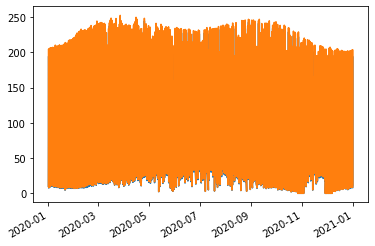

In [ ]:
evalGCR=[
        [1,0.15],
        [1,0.15],
]

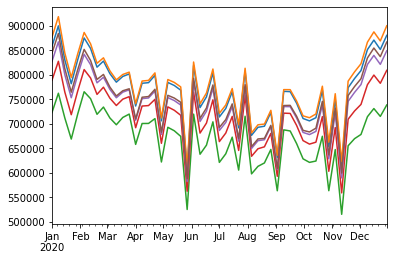

In [ ]:
for i in range(6):
    dcmeans[5-i]["p_mp"].plot()

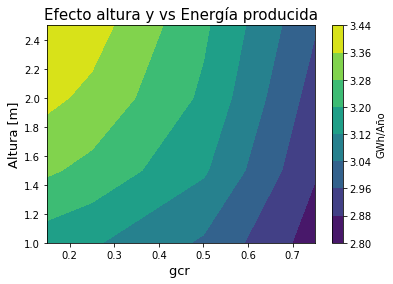

In [ ]:
x=pd.DataFrame(prods)
plt.contourf([0.15,0.25,0.5,0.75],[1,1.5,2,2.5],prods)
title='Efecto altura y vs Energía producida'
ylabel='Altura [m]'
xlabel='gcr '
plt.title(title, fontsize=15)
plt.ylabel(ylabel, fontsize=13)
plt.xlabel(xlabel, fontsize=13)
cb=plt.colorbar()
cb.set_label("GWh/Año")

# Estimación de LCOE

## Parametros del LCOE

In [ ]:
#Calculo C_M
P_modulo=1                      #cop
Area=module.A_c                          #m^2
P_r_v=2                         #Cop/m^2
P_r_f=2                         #Cop/m         
P_rack=2                        #Cop/modulo
M_Extra=0                       #Cop/modulo


#Calculo C_L
P_tierra=1                      #Cop/m^2
T_extra=2                       #Cop/m^2

#Inversión



## Código 

In [ ]:
LCOEs=[]
LCOEsi=[]
i=0

for PuntoS in Puntos_sol:
    h=PuntoS[0]
    gcr=PuntoS[1]
    Prodac=PuntoS[2]
    Prodacnorm=Prodac*1000000000/(mps_A*spi_A*Area)
    Ptot_rack=P_rack+P_r_v*h
    C_m=(P_modulo+P_rack+M_Extra)/Area      #Cop/m^2
    C_l=P_tierra+T_extra
    
    #M_m=C_m/C_l
    "Provisionalmente"
    M_m=1
    C_l=1000
    LCOE_star_i=(M_m+(1/gcr))/(Prodacnorm)*C_l
    i+=1
    
    LCOEsi.append(LCOE_star_i)
    if i==Dimension:
        
        LCOEs.append(LCOEsi)
        LCOEsi=[]
        i=0

## Gráficas

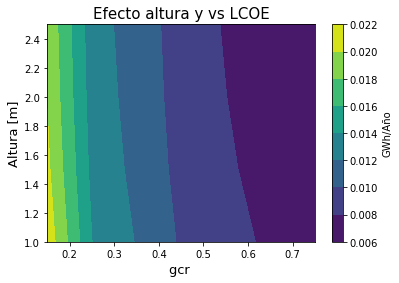

In [ ]:

plt.contourf([0.15,0.25,0.5,0.75],[1,1.5,2,2.5],LCOEs)
title='Efecto altura y vs LCOE'
ylabel='Altura [m]'
xlabel='gcr '
plt.title(title, fontsize=15)
plt.ylabel(ylabel, fontsize=13)
plt.xlabel(xlabel, fontsize=13)
cb=plt.colorbar()
cb.set_label("GWh/Año")